# Que.2

Tasks:

<ol>
  <li>Train a conditional Wasserstein GAN on the given data withclass-wise conditioning  </li>
  <li> Plot the loss curves for the Generator and Criticnetworks.</li>
  <li>Plot a 10 by 10 grid of images for generated images.  </li>
   <li>Plot a 10 by 10 grid of images for generated images for eachclass/li>
  <li> Compute the class conditional FID for all three classes taking 1000 real and generated images</li>
  <li>  Plot the generated images obtained via linear interpolation of between a pair of latent vectors.</li>
</ol>



## Imports

In [1]:
%matplotlib inline

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


/data4/home/hrishikeshj/DLNLP/envForDLNLP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyper Parameters

In [3]:
dataroot = r"/data4/home/hrishikeshj/DLNLP/ADRLA2/Dataset/train"

workers = 2
batch_size = 128
image_size = 128  ## Used for transforms
 
nc = 3  ## No of input channels in image
latent_dim = 128
ngf = 128
ndf = 32 

lr = 0.00005 #5e-4
beta1 = 0.4
ngpu = 1

num_of_classes = 3
label_emb_dim = 50

number_of_epochs = 400
learning_rate = 0.00005
weight_cliping_limit = 0.01
num_critic_steps = 5

## Preparing Data

In [16]:
torch.cuda.set_device(7)
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:7" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# images = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_of_classes, label_emb_dim)
        self.L1 = nn.Linear(label_emb_dim,20)
        self.L2 = nn.Linear(20,1)
        self.leakyRelu = nn.LeakyReLU(0.1)

        self.main = nn.Sequential(
            
            # Latent Dim : 128 x 1 x 1
            nn.ConvTranspose2d(latent_dim+1, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            
            nn.ConvTranspose2d( ngf//2, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input, label):
        #input : [bs,latent_dim]
        #label : [bs]
        input = input.view(-1,latent_dim,1,1)

        label_emb = self.label_embedding(label)
        label_emb = self.L1(label_emb)
        label_emb = self.leakyRelu(label_emb)
        label_emb = self.L2(label_emb)
        label_emb = self.leakyRelu(label_emb)
        #label_emb : [bs,1]

        input = torch.cat((input,label_emb.view(-1,1,1,1)),dim=1)

        return self.main(input)

In [10]:
netG = Generator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)


Generator(
  (label_embedding): Embedding(3, 50)
  (L1): Linear(in_features=50, out_features=20, bias=True)
  (L2): Linear(in_features=20, out_features=1, bias=True)
  (leakyRelu): LeakyReLU(negative_slope=0.1)
  (main): Sequential(
    (0): ConvTranspose2d(129, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), st

Discriminator Code



In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_of_classes, label_emb_dim)
        self.L1 = nn.Linear(label_emb_dim,image_size*image_size)
        self.leakyRelu = nn.LeakyReLU(0.1)
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input, label):
        #input : [bs, nc, H, W]
        #label : [bs]
        label_emb = self.label_embedding(label)
        label_emb = self.L1(label_emb)
        label_emb = self.leakyRelu(label_emb)
        #label_emb = [bs, 3584], 3584 = 128*128. 128 is image size
        label_emb = label_emb.view(-1, 1, image_size, image_size)
        input = torch.cat((input,label_emb),dim=1)
        return self.main(input)

In [15]:
netD = Discriminator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

Discriminator(
  (label_embedding): Embedding(3, 50)
  (L1): Linear(in_features=50, out_features=16384, bias=True)
  (leakyRelu): LeakyReLU(negative_slope=0.1)
  (main): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, 

In [17]:
d_optimizer = torch.optim.RMSprop(netD.parameters(), lr=learning_rate)
g_optimizer = torch.optim.RMSprop(netG.parameters(), lr=learning_rate)

In [6]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available else torch.LongTensor

In [ ]:
number_of_steps = number_of_epochs*len(dataloader)
progress_bar = tqdm(range(number_of_steps))

all_d_loss = []
all_g_loss = []

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]

        # Move to GPU if necessary
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        d_optimizer.zero_grad()

        # Sample noise and labels as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

        # Generate a batch of images
        fake_imgs = netG(z,labels)

        # Real images
        real_validity = netD(real_imgs,labels)
        # Fake images
        fake_validity = netD(fake_imgs,labels)

        #shape of real and fake val : - 128,1,1,1, [bs, 1,1,1]

        netD.zero_grad()

        # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit,weight_cliping_limit)

        d_loss_real = real_validity.mean(0).view(1)
        d_loss_fake = fake_validity.mean(0).view(1)
        d_loss = -d_loss_real + d_loss_fake

        

        d_loss.backward()
        d_optimizer.step()

        if i%num_critic_steps == 0:
            
            g_optimizer.zero_grad()

            # -----------------
            #  Train Generator
            # -----------------

            z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
            # Generate a batch of images
            fake_imgs = netG(z,labels)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = netD(fake_imgs,labels)
            g_loss = -fake_validity.mean(0).view(1)

            all_d_loss.append(d_loss)
            all_g_loss.append(g_loss)

            g_loss.backward()
            g_optimizer.step()

            if i%10000==0:
                print("D_loss : ",d_loss,", G_Losss : ",g_loss)
        progress_bar.update(1)

In [ ]:
model_path  = "/data4/home/hrishikeshj/DLNLP/ADRLA2/trainedModels/CWGAN200Ep"

gen_model = model_path + "/gen.pt"
desc_model = model_path + "/desc.pt"

torch.save(netG.state_dict(),gen_model)
torch.save(netD.state_dict(),desc_model)

Loss Curves For Generator And Descriminator.

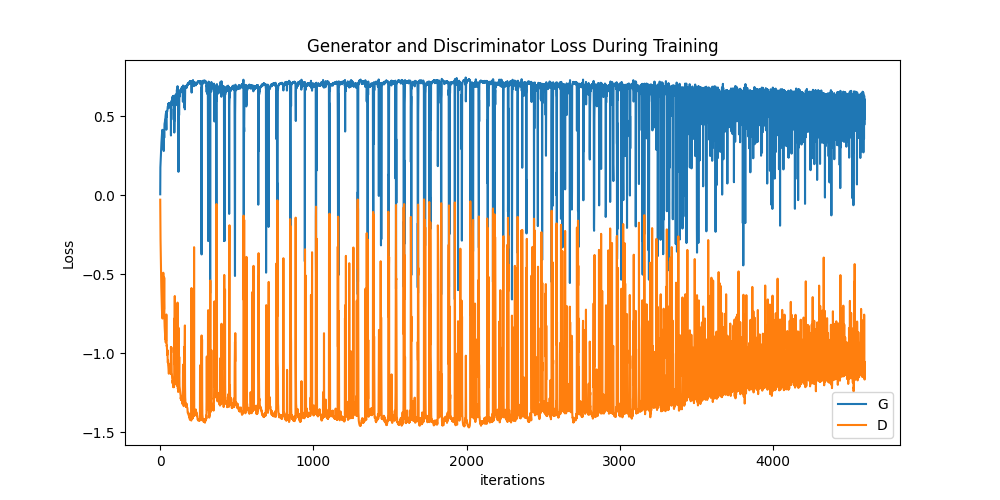

#Loading Trained Model

In [7]:
netG = Generator()
modelPath = "/data4/home/hrishikeshj/DLNLP/ADRLA2/trainedModels/CWGAN200Ep/gen.pt"
netG.load_state_dict(torch.load(modelPath))
netG = netG.to(device=device)

# 10*10 GRID of generated images
# Codeto generate Images : 

In [ ]:
z = Tensor(np.random.normal(0, 1, (100, latent_dim)))

label0 = np.array([0 for _ in range(100)])
label0 = LongTensor(label0)

label1 = np.array([1 for _ in range(100)])
label1 = LongTensor(label1)

label2 = np.array([2 for _ in range(100)])
label2 = LongTensor(label2)

fake_imgs = netG(z,label2)
img_list = []
img_list.append(vutils.make_grid(fake_imgs.detach().to('cpu'), nrow=10, padding=2, normalize=True))

fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Images For Label 0 : Cats
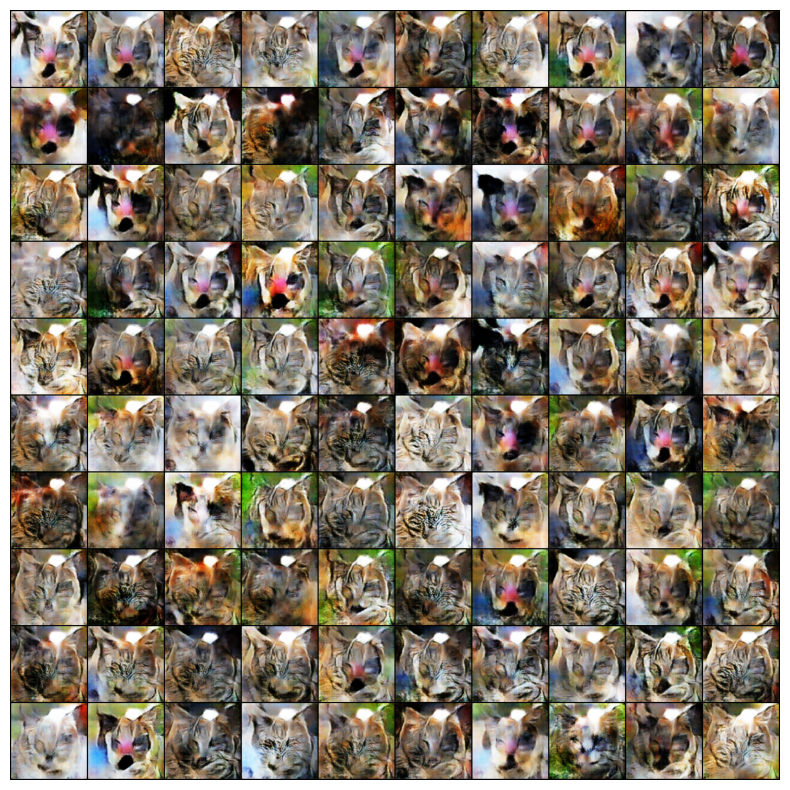

# Images for label 1 : Dogs

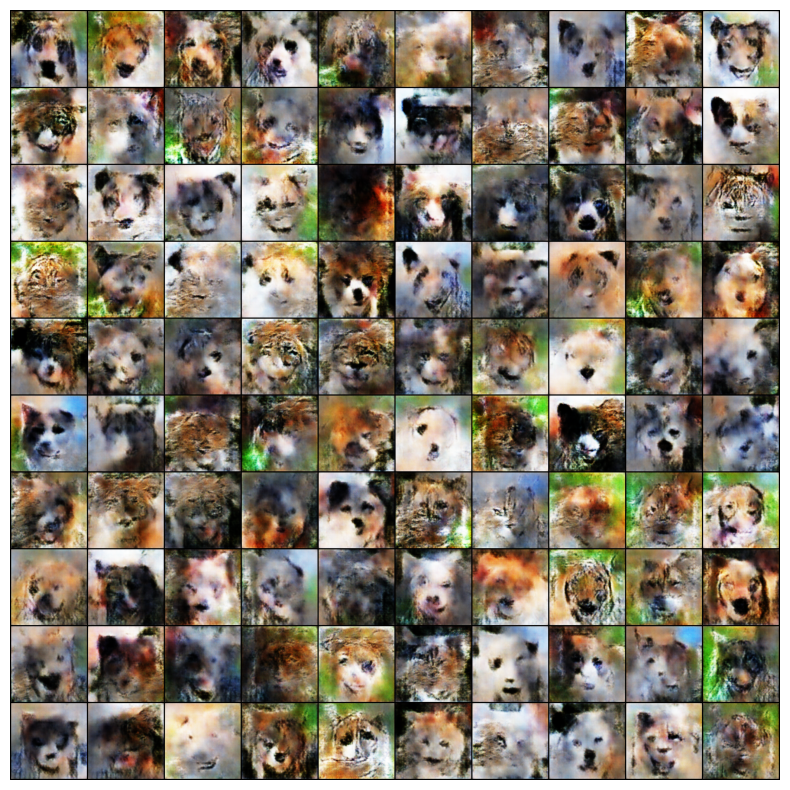

# Images for label 2 : Wild

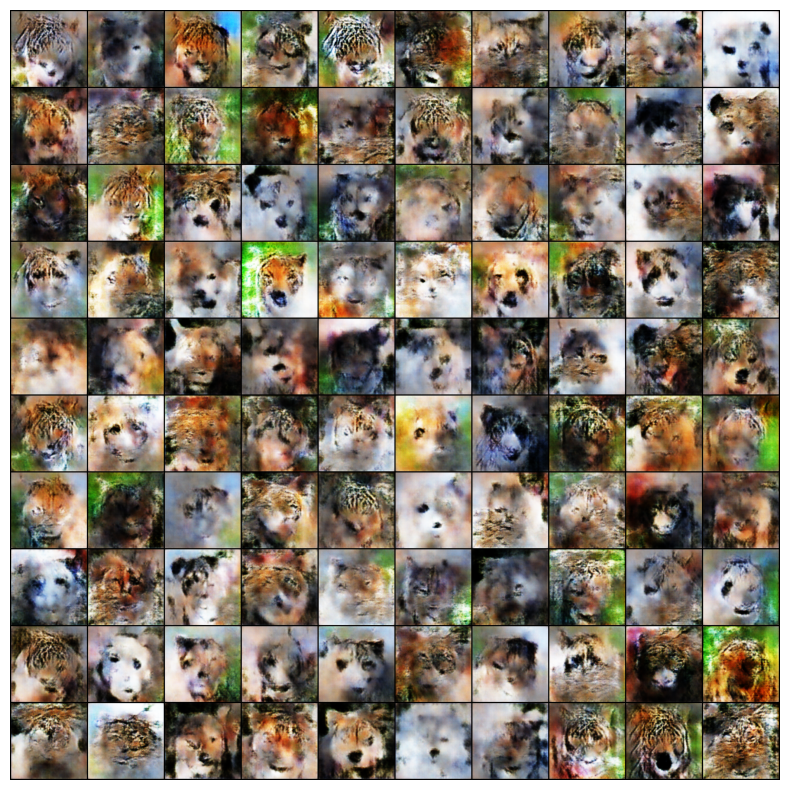

# Calculating FID Distance

# Code for storing Real and fake images in a folder

In [8]:
from torchvision.utils import save_image
from tqdm.auto import tqdm

In [ ]:
#label  0 :- 0-> 5152
#lale 1 : 5153 -> 9891
#label 2 : 9892 -> 14630
label0 = np.array([0 for _ in range(3000)])
label0 = LongTensor(label0)

label1 = np.array([1 for _ in range(3000)])
label1 = LongTensor(label1)

label2 = np.array([2 for _ in range(2000)])
label2 = LongTensor(label2)

import random
real_img = []
for i in tqdm(range(2000)):
    j = random.randint(9892, 14625)
    real_img.append(dataset[j][0])
real_img = torch.stack(real_img, dim=0)
print(real_img.shape)

print("Real images Loaded")
latents = Tensor(np.random.normal(0, 1, (2000,latent_dim)))
fake_img = netG(latents,label2)

real_image_path = "/data4/home/hrishikeshj/DLNLP/ADRLA2/trainedModels/CWGAN200Ep/TempForFID/Label2/RealImages"
fake_image_path = "/data4/home/hrishikeshj/DLNLP/ADRLA2/trainedModels/CWGAN200Ep/TempForFID/Label2/FakeImages"

for i in tqdm(range(2000)):
    imagePath = real_image_path + "/img" + "{}".format(i) + ".png"
    save_image(real_img[i],imagePath)
    
for i in tqdm(range(2000)):
    imagePath = fake_image_path + "/img" + "{}".format(i) + ".png"
    save_image(fake_img[i],imagePath)

To Calculate FID Distance We are using a pytorch library called pytorch-fid.
After saving real and fake images in two seperate folders. it can be calculated with following commands.

python -m pytorch_fid path/to/real_images path/to/fake_images

# FID For Label 0:
# 211.7155353316303


# FID for Label 1:
# 196.71078104540888

# FID for Label 2:
# 239.7200831498778

# Linear Interpolation

# Code for linear interpolation

In [26]:
label0 = np.array([0 for _ in range(1)])
label0 = LongTensor(label0)

label1 = np.array([1 for _ in range(1)])
label1 = LongTensor(label1)

label2 = np.array([2 for _ in range(1)])
label2 = LongTensor(label2)

def posterior_inference_and_interpolation(netG,num_points=10):
    latent1 = Tensor(np.random.normal(0, 1, (latent_dim)))

    latent2 = Tensor(np.random.normal(0, 1, (latent_dim)))

#     # Linearly interpolate between the latent representations
    interpolated_latents = []
    
    for alpha in np.linspace(0, 1, num_points):
        print(alpha)
        interpolated_latent = alpha * latent1 + (1 - alpha) * latent2
        interpolated_latents.append(interpolated_latent.clone())

    # Decode the interpolated latents to generate images
    interpolated_images = []
    for interpolated_latent in interpolated_latents:
        interpolated_latent = interpolated_latent.view(1,-1)
        print("Shape : ",interpolated_latent.shape)
        generated_image= netG(interpolated_latent,label2)
        interpolated_images.append(generated_image.clone())
    return interpolated_images

In [ ]:
op = posterior_inference_and_interpolation(netG)
input = torch.cat([op[i] for i in range(10)],dim=0)
img_list = []
img_list.append(vutils.make_grid(input.detach().to('cpu'), nrow=10, padding=2, normalize=True))

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Interpolation for Label 0:

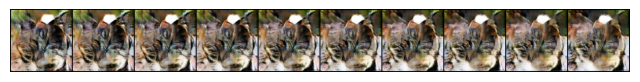

# Interpolation for Label 1:

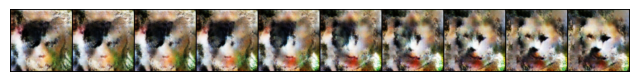

# Interpolation for Label 2:

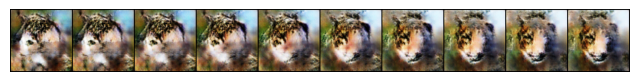